In [ ]:
# Imports

import re
import os
import string
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from scipy.stats import skew
from collections import Counter, defaultdict

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Downloading dataset

!rm -rf pubmed-rct
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
^C


In [ ]:
# Global variables

DATA_DIR = '/content/drive/MyDrive/SCRIPTS/TensorflowRoot/Data/PubMed_200k_RCT'

In [ ]:
# Loading data functions

def parse_abstract(lines):
    """
    Parses lines of an abstract into a list of dictionaries, each containing line number,
    target, text, and total_lines.

    :param lines: List of lines in an abstract
    :return: List of dictionaries with parsed data
    """
    abstract_data = []
    for i, line in enumerate(lines):
        line_split = line.strip().split('\t', 1)
        if len(line_split) == 2:  # Ensure the line has both target and text
            abstract_data.append({
                'line_number': i,
                'target': line_split[0],
                'text': line_split[1],
            })
    # Add total_lines to each entry in the abstract
    total_lines = len(abstract_data)
    for entry in abstract_data:
        entry['total_lines'] = total_lines
    return abstract_data


def load_data(data_dir):
    """
    Loads data from text files in the specified directory and organizes it into
    train, test, and dev datasets, along with a set of unique labels.

    :param data_dir: The directory containing the data files.
    :return: A tuple containing lists for train, test, and dev data, and a set of labels.
    """
    train_data, test_data, dev_data = [], [], []

    pattern = re.compile(r'^#{3}\d+')

    for file_name in os.listdir(data_dir):
        if 'train' in file_name:
            current_data = train_data
        elif 'dev' in file_name:
            current_data = dev_data
        elif 'test' in file_name:
            current_data = test_data
        else:
            continue  # Skip files that don't match any category

        with open(os.path.join(data_dir, file_name), 'r', encoding='utf-8') as file:
            abstract_lines = []
            for line in file:
                if pattern.match(line):
                    if abstract_lines:  # If starting a new abstract, parse the previous one
                        current_data.extend(parse_abstract(abstract_lines))
                        abstract_lines = []
                else:
                    abstract_lines.append(line)
            if abstract_lines:  # Ensure the last abstract is also processed
                current_data.extend(parse_abstract(abstract_lines))

    return train_data, test_data, dev_data


def get_str_labels(data):
    return list(map(lambda sent: sent['target'], data))

In [ ]:
# Loading data

train_data, test_data, dev_data = load_data(data_dir=DATA_DIR)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Data Analysis

STOPWORDS = set(stopwords.words('english'))

class Analyzer:
    def __init__(self, data):
        self.data = data
        self.df = pd.DataFrame(data)
        self.label_distribution = self.df.target.value_counts()
        self.total_lines_distribution = self.df.total_lines.plot.hist
        self.sentences = self.df.text.to_list()
        self.sentence_lengths = [len(sentence.split()) for sentence in self.sentences]
        self.mean_sentence_length = np.mean(self.sentence_lengths)
        self.best_sentence_coverage = np.percentile(self.sentence_lengths, 95)
        self.maximum_sentence_length = max(self.sentence_lengths)
        self.vocabulary_size = len(set(word for string in self.sentences for word in string.split() if word not in STOPWORDS))
        self.sentence_lengths_by_chars = [len(sentence) for sentence in self.sentences]
        self.best_sentence_coverage_by_chars = np.percentile(self.sentence_lengths_by_chars, 95)
        self.mean_sentence_lengths_by_chars = np.mean(self.sentence_lengths_by_chars)
        self.line_numbers = self.df.line_number.to_list()
        self.line_number_distribution_list = self.df.line_number.value_counts()
        self.best_line_number_coverage = np.percentile(self.line_numbers, 95)

    def sentence_lengths_distribution(self):
        self.sentence_lengths_distribution = plt.hist(self.sentence_lengths, bins=20)

    def sentence_lengths_distribution_by_chars(self):
        self.sentence_lengths_distribution_by_chars = plt.hist(self.sentence_lengths_by_chars, bins=20)

    def line_number_distribution(self):
        self.df.line_number.plot.hist()

In [ ]:
train_data_analyzer = Analyzer(train_data)

In [ ]:
# Overview of saved dataset attributes

train_data_analyzer.df

,line_number,target,text,total_lines
0,0,BACKGROUND,The emergence of HIV as a chronic condition me...,11
1,1,BACKGROUND,This paper describes the design and evaluation...,11
2,2,METHODS,This study is designed as a randomised control...,11
3,3,METHODS,The intervention group will participate in the...,11
4,4,METHODS,The program is based on self-efficacy theory a...,11
...,...,...,...,...
2211856,5,METHODS,"After crossover , the wait-list group received...",10
2211857,6,METHODS,Performance was assessed by comparison to Amer...,10
2211858,7,RESULTS,Performance improved significantly after simul...,10
2211859,8,RESULTS,No improvement was detected as a function of c...,10


In [ ]:
# Distribution of target labels

train_data_analyzer.label_distribution

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

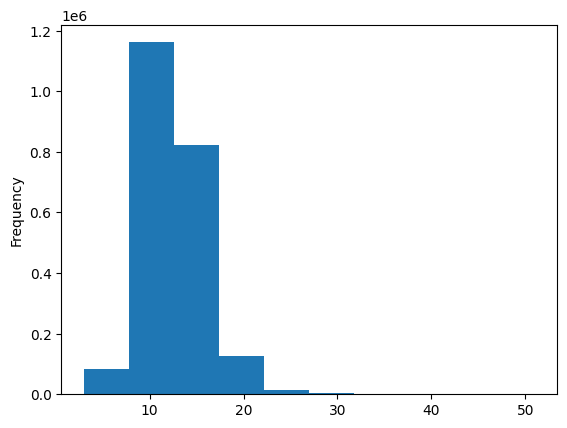

In [ ]:
# Distribution of the abstracts' lengths

train_data_analyzer.total_lines_distribution()

In [ ]:
# Mean/Average sentence length

train_data_analyzer.mean_sentence_length

26.229355280462922

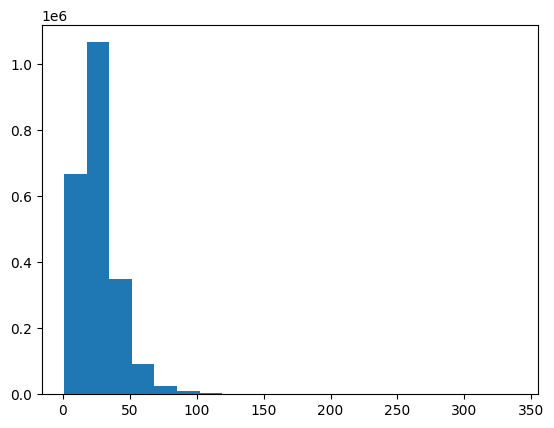

In [ ]:
# Sentence lengths distribution

train_data_analyzer.sentence_lengths_distribution()

In [ ]:
# 95th percent of all sentences have this or shorter length

sequence_length = train_data_analyzer.best_sentence_coverage
print(sequence_length)

54.0


In [ ]:
# Maximum sentence length

max_sequence_length = train_data_analyzer.maximum_sentence_length
print(max_sequence_length)

338


In [ ]:
# Vocabulary size (number of unique words, word being everything that is not a stopword)

vocab_size = train_data_analyzer.vocabulary_size
print(vocab_size)

471880


In [ ]:
# Average sentence length by chars

train_data_analyzer.mean_sentence_lengths_by_chars

150.52200567757197

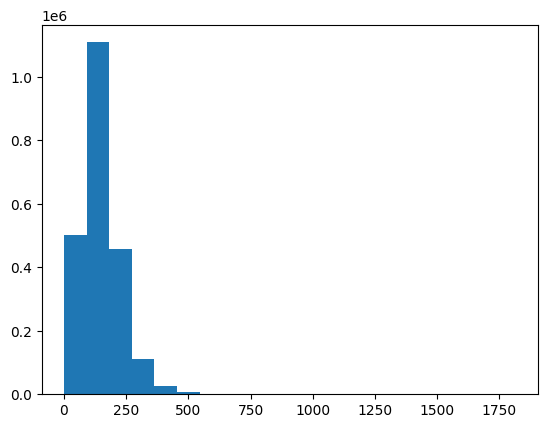

In [ ]:
# Sentence lengths distribution (by chars)

train_data_analyzer.sentence_lengths_distribution_by_chars()

In [ ]:
# 95th percent of all sentences have this or shorter length (by chars)

char_sequence_length = train_data_analyzer.best_sentence_coverage_by_chars
print(char_sequence_length)

291.0


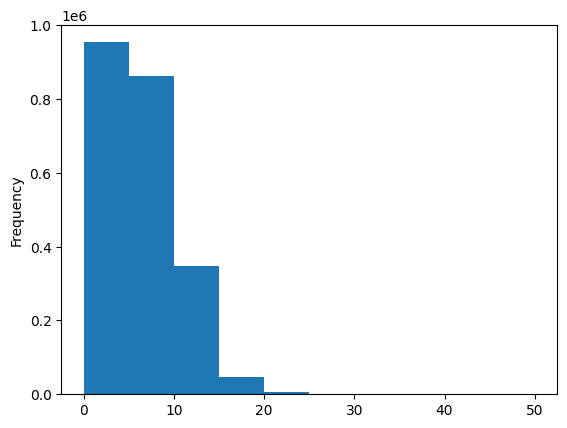

In [ ]:
train_data_analyzer.line_number_distribution()

In [ ]:
line_number_dim = train_data_analyzer.best_line_number_coverage
print(line_number_dim)

13.0


In [ ]:
# Encoding labels to int-arrays/one-hots and sentences to str-arrays

LABEL_INT_MAPPING = {
    'BACKGROUND': 0,
    'OBJECTIVE': 1,
    'METHODS': 2,
    'RESULTS': 3,
    'CONCLUSIONS': 4,
}

INT_LABEL_MAPPING = {value: key for key, value in LABEL_INT_MAPPING.items()}

LABELS_N = 5


def one_hot_labels(data):
    int_labels = str_to_int_labels(data)
    return tf.one_hot(int_labels, depth=LABELS_N)


def str_to_int_labels(data):
    return list(map(lambda x: LABEL_INT_MAPPING[x], [item['target'] for item in data]))


def get_sents(data):
    return [abstract['text'] for abstract in data]

In [ ]:
# Converting data labels into int-Tokens
train_labels = str_to_int_labels(train_data)
test_labels = str_to_int_labels(test_data)
dev_labels = str_to_int_labels(dev_data)

# Extracting lists of sentences from each dataset
train_texts = get_sents(train_data)
test_texts = get_sents(test_data)
dev_texts = get_sents(dev_data)

# Converting data labels to one-hot encodings
train_labels_one_hot = one_hot_labels(train_data)
test_labels_one_hot = one_hot_labels(test_data)
dev_labels_one_hot = one_hot_labels(dev_data)

In [ ]:
class MultinomialNBBase():
    def __init__(self, x_train, y_train, x_test, y_test, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_val = x_val
        self.y_val = y_val
        self.model = MultinomialNB()

    def vectorize(self):
        vectorizer = TfidfVectorizer(lowercase=True)
        self.x_train_vec = vectorizer.fit_transform(self.x_train)
        self.x_test_vec = vectorizer.transform(self.x_test)

    def fit(self):
        self.model.fit(self.x_train_vec, self.y_train)

    def train(self):
        self.vectorize()
        self.fit()

    def evaluate(self, mode='print'):
        y_pred = self.model.predict(self.x_test_vec)
        average = 'weighted'
        metrics = {
            'accuracy': self.model.score(self.x_test_vec, self.y_test),
            'f1_score': f1_score(y_true=self.y_test,
                                 y_pred=y_pred,
                                 average=average),
        }
        if mode == 'print':
            for metric, value in metrics.items():
                print("{0}\t{1}".format(metric, value))
        else:
            return metrics

In [ ]:
MultinomialNBBase = MultinomialNBBase(
    train_texts,
    train_labels,
    test_texts,
    test_labels,
    dev_texts,
    dev_labels
)
MultinomialNBBase.train()
MultinomialNBBase.evaluate()

accuracy	0.7649950835791544
f1_score	0.754122108843251


In [ ]:
class EmbeddingConv1DBase():
    def __init__(self, x_train, y_train, x_test, y_test, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_val = x_val
        self.y_val = y_val
        self.num_words = 300_000
        self.oov_token = '<OOV>'
        self.seq_len = 64
        self.output_dim = 128
        self.epochs = 10
        self.loss = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model = tf.keras.Sequential()

    def tokenize(self):
        tokenizer = Tokenizer(num_words=self.num_words,
                              oov_token=self.oov_token,
                              lower=True)
        tokenizer.fit_on_texts(self.x_train)

        self.x_train_toks = tokenizer.texts_to_sequences(self.x_train)
        self.x_train_toks = pad_sequences(self.x_train_toks,
                                          padding='post',
                                          maxlen=self.seq_len,
                                          truncating='post')

        self.x_test_toks = tokenizer.texts_to_sequences(self.x_test)
        self.x_test_toks = pad_sequences(self.x_test_toks,
                                         padding='post',
                                         maxlen=self.seq_len,
                                         truncating='post')

        self.x_val_toks = tokenizer.texts_to_sequences(self.x_val)
        self.x_val_toks = pad_sequences(self.x_val_toks,
                                        padding='post',
                                        maxlen=self.seq_len,
                                        truncating='post')

    def prep_dataset(self):
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train_toks, self.y_train)).batch(64).prefetch(
            tf.data.AUTOTUNE)
        self.test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test_toks, self.y_test)).batch(64).prefetch(
            tf.data.AUTOTUNE)
        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.x_val_toks, self.y_val)).batch(64).prefetch(
            tf.data.AUTOTUNE)

    def create_model(self):
        self.model.add(tf.keras.layers.Embedding(input_dim=self.num_words,
                                                 output_dim=self.output_dim,
                                                 input_length=self.seq_len))
        self.model.add(tf.keras.layers.Conv1D(filters=32,
                                              kernel_size=6,
                                              padding='same',
                                              activation='relu'))
        self.model.add(tf.keras.layers.GlobalAveragePooling1D())
        self.model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        self.model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

        self.model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        self.model.summary()

    def fit(self):
        self.history = self.model.fit(x=self.train_dataset,
                                      epochs=self.epochs,
                                      validation_data=self.val_dataset,
                                      steps_per_epoch=int(0.1 * len(self.train_dataset)),
                                      validation_steps=int(0.1 * len(self.val_dataset)),
                                      verbose=2)

    def evaluate(self):
        y_pred = self.model.predict(self.test_dataset)
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_pred, self.y_test)
        print("{0}\t{1}".format('accuracy', accuracy.result()))
        f1 = tf.keras.metrics.F1Score(average='weighted')
        f1.update_state(y_pred, self.y_test)
        print("{0}\t{1}".format('f1_score', f1.result()))


    def train(self):
        self.tokenize()
        self.prep_dataset()
        self.create_model()
        self.fit()

In [ ]:
EmbeddingConv1DBase = EmbeddingConv1DBase(
    train_texts,
    train_labels_one_hot,
    test_texts,
    test_labels_one_hot,
    dev_texts,
    dev_labels_one_hot
)
EmbeddingConv1DBase.train()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 128)           38400000  
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 32)            24608     
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 38427045 (146.59 MB)
Trainable params: 38427045 (146.59 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
EmbeddingConv1DBase.evaluate()

461/461 [==============================] - 1s 2ms/step
accuracy	0.8554233312606812
f1_score	0.7957361340522766


In [ ]:
# Function to split sentences by characters

def get_sents_split_by_chars(data):
  return [" ".join(list(item['text'])) for item in data]

In [ ]:
# Creating character-based datasets

train_chars = get_sents_split_by_chars(train_data)
test_chars = get_sents_split_by_chars(test_data)
dev_chars = get_sents_split_by_chars(dev_data)

T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .


In [ ]:
# Positional encoding of line numbers

def positional_encoding(data):
  line_numbers = [[item['line_number'], item['total_lines']] for item in data]
  line_numbers_tf = tf.constant(line_numbers, dtype=tf.float32)
  max_line_number = tf.reduce_max(line_numbers_tf)
  min_line_number = tf.reduce_min(line_numbers_tf)
  positional_encoding = (line_numbers_tf - min_line_number) / (max_line_number - min_line_number)
  return positional_encoding

In [ ]:
train_positions = positional_encoding(train_data)
test_positions = positional_encoding(test_data)
dev_positions = positional_encoding(dev_data)

In [ ]:
class PoseidonLSTM():
    def __init__(self,
                 x_train_sents,
                 x_train_chars,
                 x_train_pos,
                 y_train,
                 x_test_sents,
                 x_test_chars,
                 x_test_pos,
                 y_test,
                 x_val_sents,
                 x_val_chars,
                 x_val_pos,
                 y_val):
        self.x_train_sents = x_train_sents
        self.x_train_chars = x_train_chars
        self.x_train_pos = x_train_pos
        self.y_train = y_train
        self.x_test_sents = x_test_sents
        self.x_test_chars = x_test_chars
        self.x_test_pos = x_test_pos
        self.y_test = y_test
        self.x_val_sents = x_val_sents
        self.x_val_chars = x_val_chars
        self.x_val_pos = x_val_pos
        self.y_val = y_val
        self.num_chars = len(string.ascii_lowercase + string.digits + string.punctuation) + 12 # ASCII set size = 68;
        self.char_seq_len = 296
        self.embeddings_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
        self.learning_rate = 1e-2
        self.label_smoothing = 0.2
        self.loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=self.label_smoothing)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.epochs = 10
        self.callback_monitor = 'val_accuracy'
        self.callback_patience = 3
        self.model_monitor = 'val_accuracy'
        self.model_save = 'poseidon_lstm'
        self.earlyCallback = tf.keras.callbacks.EarlyStopping(monitor=self.callback_monitor, patience=self.callback_patience)
        self.checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=self.model_save, monitor=self.model_monitor, save_best_only=True)


    def chars_vectorize(self):
        self.char_vectors = tf.keras.layers.TextVectorization(
            max_tokens = self.num_chars,
            output_sequence_length = self.char_seq_len,
            name = 'char_vectors'
        )
        local_char_dataset = tf.data.Dataset.from_tensor_slices(self.x_train_chars).batch(32).prefetch(tf.data.AUTOTUNE)
        self.char_vectors.adapt(local_char_dataset)
        del local_char_dataset

    def prep_datasets(self):
        def ds(sentences, chars, positions, one_hot_labels):
          char_token_pos_data = tf.data.Dataset.from_tensor_slices((sentences, chars, positions))
          labels = tf.data.Dataset.from_tensor_slices(one_hot_labels)
          char_token_pos_dataset = tf.data.Dataset.zip(char_token_pos_data, labels).batch(32).prefetch(tf.data.AUTOTUNE)
          return char_token_pos_dataset

        self.train_dataset = ds(self.x_train_sents, self.x_train_chars, self.x_train_pos, self.y_train)
        self.test_dataset = ds(self.x_test_sents, self.x_test_chars, self.x_test_pos, self.y_test)
        self.val_dataset = ds(self.x_val_sents, self.x_val_chars, self.x_val_pos, self.y_val)

    def create_model(self):
        # 1. Leg: Word Embedding
        token_input =  tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_input')
        word_embeddings = hub.KerasLayer(
            self.embeddings_url,
            trainable = False,
            name = 'USE_word_embeddings'
        )(token_input)
        token_output = tf.keras.layers.Dense(128, activation = 'relu')(word_embeddings)
        token_model = tf.keras.Model(inputs = token_input, outputs = token_output)

        # 2. Leg: Character Embeddings + BiLSTM
        char_input = tf.keras.layers.Input(shape =(1,), dtype = tf.string, name='char_input')
        char_vectors = self.char_vectors(char_input)
        char_embeddings = tf.keras.layers.Embedding(
            input_dim = self.num_chars,
            output_dim = 32,
            mask_zero = True,
            name = 'char_embeddings'
        )(char_vectors)
        char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
        char_model = tf.keras.Model(inputs = char_input, outputs = char_bi_lstm)

        # 3. Leg: Positional Encodings
        line_number_total_lines_input = tf.keras.layers.Input(shape=(2,), dtype = tf.float32, name='line_number_total_line_input')
        x = tf.keras.layers.Dense(24, activation='relu')(line_number_total_lines_input)
        line_number_total_lines_model = tf.keras.Model(inputs=line_number_total_lines_input, outputs=x)

        # Word-char Embeddings Concatenation
        token_char_concat = tf.keras.layers.Concatenate(name='token_char_concat')([
            token_model.output,
            char_model.output
        ])

        token_char_concat_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)

        # Word-char-positions Concatenation
        fork = tf.keras.layers.Concatenate(name='token_char_pos_concat')([
            token_char_concat_dropout,
            line_number_total_lines_model.output
        ])

        # Output layers
        combined_dropout = tf.keras.layers.Dropout(0.5)(fork)
        combined_lstm = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
        final_dropout = tf.keras.layers.Dropout(0.5)(combined_lstm)
        output_layer = tf.keras.layers.Dense(5, activation = 'softmax')(final_dropout)

        self.model = tf.keras.Model(inputs = [token_model.input, char_model.input, line_number_total_lines_model.input], outputs = output_layer, name = 'poseidon_lstm')

        self.model.compile(
            loss = self.loss,
            optimizer = self.optimizer,
            metrics = ['accuracy']
        )

        self.model.summary()

    def plot_learning_curves(self):
      plt.plot(self.history.history['loss'])
      plt.plot(self.history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Val'], loc='upper left')
      plt.show()

      plt.plot(self.history.history['accuracy'])
      plt.plot(self.history.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Val'], loc='upper left')
      plt.show()

    def fit(self):
        self.history = self.model.fit(
            self.train_dataset,
            validation_data = self.val_dataset,
            steps_per_epoch = int(0.01 * len(self.train_dataset)),
            validation_steps = int(0.01 * len(self.val_dataset)),
            epochs = self.epochs,
            callbacks=[self.earlyCallback, self.checkpointCallback]
        )

    def evaluate(self):
        y_pred = self.model.predict(self.test_dataset)
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_pred, self.y_test)
        print("{0}\t{1}".format('accuracy', accuracy.result()))
        f1 = tf.keras.metrics.F1Score(average='weighted')
        f1.update_state(y_pred, self.y_test)
        print("{0}\t{1}".format('f1_score', f1.result()))

    def train(self):
        self.chars_vectorize()
        self.prep_datasets()
        self.create_model()
        self.fit()

In [ ]:
PoseidonLSTM = PoseidonLSTM(
    train_texts,
    train_chars,
    train_positions,
    train_labels_one_hot,
    test_texts,
    test_chars,
    test_positions,
    test_labels_one_hot,
    dev_texts,
    dev_chars,
    dev_positions,
    dev_labels_one_hot
)

In [ ]:
PoseidonLSTM.train()

Model: "poseidon_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectors (TextVectoriz  (None, 296)                  0         ['char_input[0][0]']          
 ation)                                                                                           
                                                                                                  
 USE_word_embeddings (Keras  (None, 512)                  2567978   ['token_input[0][0

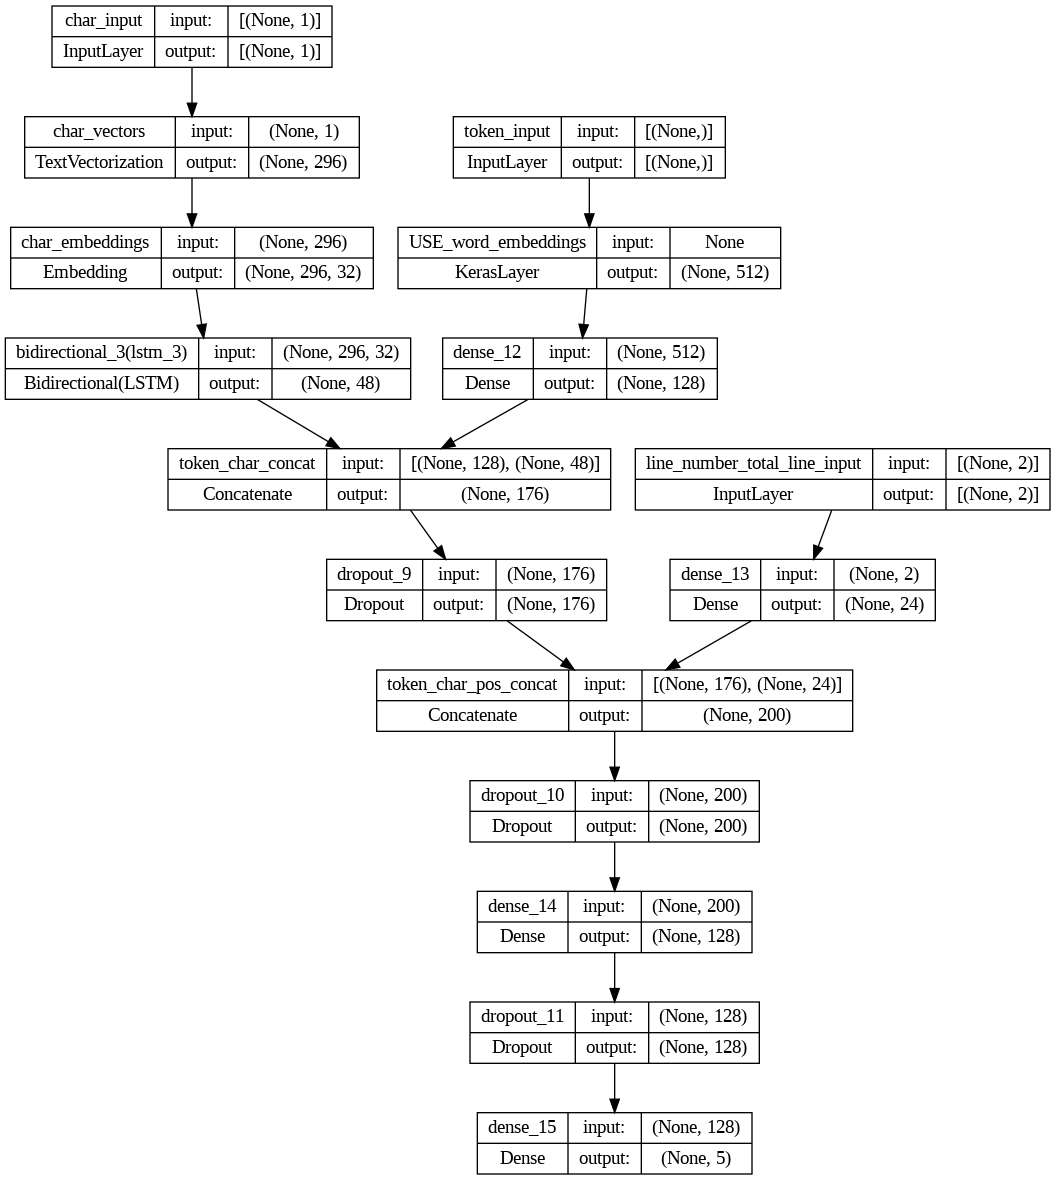

In [ ]:
plot_model(PoseidonLSTM.model, show_shapes=True)

In [ ]:
PoseidonLSTM.evaluate()

922/922 [==============================] - 21s 20ms/step
accuracy	0.7962567210197449
f1_score	0.5669800043106079


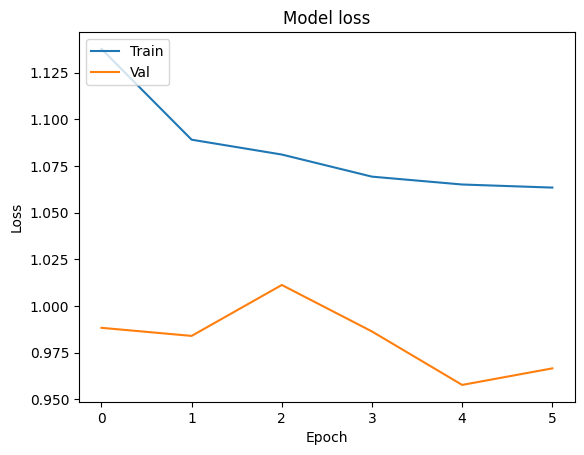

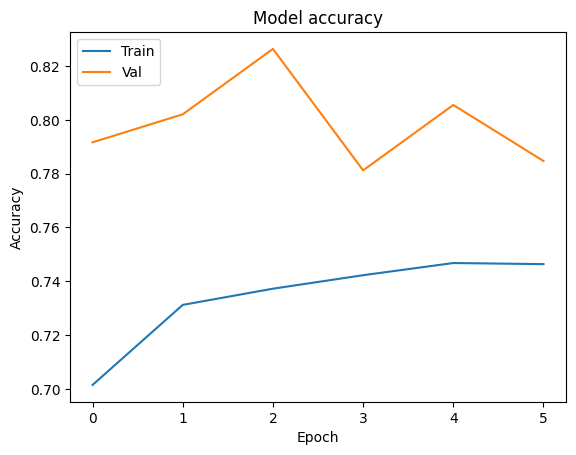

In [ ]:
PoseidonLSTM.plot_learning_curves()

In [ ]:
# Testing saved model

model_path = "/content/drive/MyDrive/SCRIPTS/JupyterRoot/NeuralNets/poseidon_lstm"
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "poseidon_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectors (TextVectoriz  (None, 296)                  0         ['char_input[0][0]']          
 ation)                                                                                           
                                                                                                  
 USE_word_embeddings (Keras  (None, 512)                  2567978   ['token_input[0][0

In [ ]:
def predict(sentences):

    processed_sentences = []
    processed_chars = []
    positions = []

    for i, sentence in enumerate(sentences):
        # For sentences
        processed_sentence = tf.constant([sentence])  # Model expects batch dimension
        processed_sentences.append(processed_sentence)

        # For characters
        sentence_chars = " ".join(list(sentence))
        processed_chars.append(tf.constant([sentence_chars]))  # Model expects batch dimension

        # For positional encoding
        position_encoding = tf.constant([[i, len(sentences)]], dtype=tf.float32)
        positions.append(position_encoding)

    # Predict classes for each sentence
    predictions = []
    for sent, chars, pos in zip(processed_sentences, processed_chars, positions):
        pred = model.predict([sent, chars, pos])
        predicted_class = np.argmax(pred, axis=1)
        predictions.append(predicted_class.item())

    predictions = [INT_LABEL_MAPPING[label] for label in predictions]

    return predictions

In [ ]:
def structure_sentences(sentences, predictions):

    # Group sentences by their predicted labels
    grouped_sentences = defaultdict(list)
    for sentence, prediction in zip(sentences, predictions):
        grouped_sentences[prediction].append(sentence)

    # Construct the structured text
    structured_text = ""
    for label, sentences in grouped_sentences.items():
        structured_text += f"{label}:\n" + " ".join(sentences) + "\n\n"

    return structured_text.strip()

In [ ]:
nltk.download('punkt')
raw_abstract = "Protein folding should be complex. Proteins organize themselves into specific three-dimensional structures, through a myriad of conformational changes. The classical view of protein folding describes this process as a nearly sequential series of discrete intermediates. In contrast, the energy landscape theory of folding considers folding as the progressive organization of an ensemble of partially folded structures through which the protein passes on its way to the natively folded structure. As a result of evolution, proteins have a rugged funnel-like landscape biased toward the native structure. Connecting theory and simulations of minimalist models with experiments has completely revolutionized our understanding of the underlying mechanisms that control protein folding."
sentences = nltk.sent_tokenize(raw_abstract)
predictions = predict(sentences)
struct_sents = structure_sentences(sentences, predictions)

print(struct_sents)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1/1 [==============================] - 0s 96ms/step
OBJECTIVE:
Protein folding should be complex. Proteins organize themselves into specific three-dimensional structures, through a myriad of conformational changes.

METHODS:
The classical view of protein folding describes this process as a nearly sequential series of discrete intermediates. In contrast, the energy landscape theory of folding considers folding as the progressive organization of an ensemble of partially folded structures through which the protein passes on its way to the natively folded structure.

RESULTS:
As a result of evolution, proteins have a rugged funnel-like landscape biased toward the native structure.

CONCLUSIONS:
Connecting theory and simulations of minimalist models with experiments has completely revolutionized our understanding of the underlying mechanisms that control protein folding.
